# Treinamento da rede para predição de incêndio

A rede utilizada para predição de incêndio é a VGG-16 (http://www.robots.ox.ac.uk/~vgg/research/very_deep/). 

## Definição dos endereços utilizados neste notebook

In [1]:
# Dados para treinamento
train_data_dir = '../datasets/FireIds'

# Dados para teste
test_data_dir = '../datasets/Validation'

# Modelos
models_dir = '../models/'

# Nome da rede pré-treinada
vgg16_name = 'vgg16_weights.h5'

# Nome da rede para detecção de incêndio
fire_vgg16_name = 'fire_vgg16_weights2.h5'

# Hostórico do modelo treinado
fire_model = 'fire_detection'

## Parâmetros para o treinamento

In [2]:
# Quantidade de exemplos utilizados no treinamento
nb_train_samples = 400

# Quantidade de exemplos utilizados no teste
nb_test_samples = 90

In [3]:
import numpy as np
import numpy.random as nr
import os
os.environ['THEANO_FLAGS'] = "device=gpu0,floatX=float32"  

In [4]:
%matplotlib inline
import matplotlib.pylab as plt
import matplotlib.pyplot as plot
import h5py

from keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from keras.models import Sequential
from keras.layers import Convolution2D, MaxPooling2D, ZeroPadding2D
from keras.layers import Activation, Dropout, Flatten, Dense
from keras import backend as K
from keras.utils import np_utils

import sys
#sys.path.append('../src')
from my_keras_utilities import TrainingPlotter, load_model_and_history

K.set_image_dim_ordering('th')

Using Theano backend.
Using gpu device 0: GeForce 830M (CNMeM is disabled, cuDNN 5110)
/opt/conda/lib/python2.7/site-packages/theano/sandbox/cuda/__init__.py:600: UserWarning: Your cuDNN version is more recent than the one Theano officially supports. If you see any problems, try updating Theano or downgrading cuDNN to version 5.
  warnings.warn(warn)


## Definição da CNN

In [5]:
# Carrega o modelo da VGG-16 com seus devidos pesos sem as camadas densas (totalmente conectadas)
def get_tr_vgg_model(weights_path, img_width, img_height):
    
    model = Sequential()
    model.add(ZeroPadding2D((1, 1), input_shape=(3, img_width, img_height)))

    model.add(Convolution2D(64, 3, 3, activation='relu', name='conv1_1'))
    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(64, 3, 3, activation='relu', name='conv1_2'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))

    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(128, 3, 3, activation='relu', name='conv2_1'))
    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(128, 3, 3, activation='relu', name='conv2_2'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))

    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(256, 3, 3, activation='relu', name='conv3_1'))
    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(256, 3, 3, activation='relu', name='conv3_2'))
    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(256, 3, 3, activation='relu', name='conv3_3'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))

    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(512, 3, 3, activation='relu', name='conv4_1'))
    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(512, 3, 3, activation='relu', name='conv4_2'))
    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(512, 3, 3, activation='relu', name='conv4_3'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))

    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(512, 3, 3, activation='relu', name='conv5_1'))
    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(512, 3, 3, activation='relu', name='conv5_2'))
    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(512, 3, 3, activation='relu', name='conv5_3'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))

    # Carrega os pesos necesários até o último bloco da VGG-15 anterior as camadas densas
    assert os.path.exists(weights_path), 'Model weights not found (see "weights_path" variable in script).'
    
    f = h5py.File(weights_path)
    for k in range(f.attrs['nb_layers']):
        if k >= len(model.layers):
            break
        g = f['layer_{}'.format(k)]
        weights = [g['param_{}'.format(p)] for p in range(g.attrs['nb_params'])]
        model.layers[k].set_weights(weights)
    f.close()
    
    print ('Model loaded.')
    
    return model

# Carregando e Normalizando os dados

In [6]:
fire_train_files = os.listdir(train_data_dir+'/fire')
fire_test_files  = os.listdir(test_data_dir +'/fire')

not_fire_train_files = os.listdir(train_data_dir+'/not_fire')
not_fire_test_files  = os.listdir(test_data_dir +'/not_fire')

image_train_filenames = []
for i in range(0,nb_train_samples):
    fn = '{}/fire/{}'.format(train_data_dir, fire_train_files[i])
    image_train_filenames.append(fn)
    fn = '{}/not_fire/{}'.format(train_data_dir, not_fire_train_files[i])
    image_train_filenames.append(fn)
    
image_test_filenames = []
for i in range(0,nb_test_samples):
    fn = '{}/fire/{}'.format(test_data_dir, fire_test_files[i])
    image_test_filenames.append(fn)
    fn = '{}/not_fire/{}'.format(test_data_dir, not_fire_test_files[i])
    image_test_filenames.append(fn)
    
img_width, img_height = 85, 128 #340, 512

X_train = np.empty((2*nb_train_samples, 3, img_width, img_height), np.uint8)
y_train = np.empty((2*nb_train_samples,), np.int32)

for i, fn in enumerate(image_train_filenames):
    y_train[i] = 1 if fn.split('/')[-2] == 'fire' else 0
    img = load_img(fn, grayscale=False, target_size=(img_width, img_height))
    X_train[i] = img_to_array(img, dim_ordering='th')

X_test = np.empty((2*nb_test_samples, 3, img_width, img_height), np.uint8)
y_test = np.empty((2*nb_test_samples,), np.int32)
for i, fn in enumerate(image_test_filenames):
    y_test[i] = 1 if fn.split('/')[-2] == 'fire' else 0
    img = load_img(fn, grayscale=False, target_size=(img_width, img_height))
    X_test[i] = img_to_array(img, dim_ordering='th')
    
y_train = y_train.ravel()
y_test = y_test.ravel()

n_train = nb_train_samples
n_test  = nb_test_samples

# Transforma o vetor de labels para o formato de one-hot encoding.
Y_train = np_utils.to_categorical(y_train)[:n_train]
Y_test = np_utils.to_categorical(y_test)[:n_test]

#Normalização dos dados
X_train = X_train.astype('float32')[:n_train]
X_test = X_test.astype('float32')[:n_test]
X_train /= 255
X_test /= 255

img_width, img_height = X_train.shape[2:]

print X_train.shape
print X_test.shape
print Y_train.shape
print Y_test.shape

(400, 3, 85, 128)
(90, 3, 85, 128)
(400, 2)
(90, 2)


## Carregando e inicializando pesos da CNN

In [7]:
# Caminho pesos da VGG-16
weights_path = models_dir+vgg16_name

# Carrega o modelo até a última camada convolucional
vgg16_tr_model = get_tr_vgg_model(weights_path, img_width, img_height)

# Execute esse comando para conhecer a arquitetura das camadas convolucionais da VGG-16

print 'n de camadas:',len(vgg16_tr_model.layers)
print vgg16_tr_model.summary()


Model loaded.
n de camadas: 31
____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
zeropadding2d_1 (ZeroPadding2D)  (None, 3, 87, 130)    0           zeropadding2d_input_1[0][0]      
____________________________________________________________________________________________________
conv1_1 (Convolution2D)          (None, 64, 85, 128)   1792        zeropadding2d_1[0][0]            
____________________________________________________________________________________________________
zeropadding2d_2 (ZeroPadding2D)  (None, 64, 87, 130)   0           conv1_1[0][0]                    
____________________________________________________________________________________________________
conv1_2 (Convolution2D)          (None, 64, 85, 128)   36928       zeropadding2d_2[0][0]            
____________________________________________________________

## Preparando camadas de classificação

In [8]:
############ Novas camadas ###########
vgg16_tr_model.add(Flatten())
vgg16_tr_model.add(Dense(512,activation='relu'))
vgg16_tr_model.add(Dropout(0.5))
vgg16_tr_model.add(Dense(2,activation='softmax'))
######################################

n = 31  # número de camadas que não serão re-treinadas

# Congela as camadas até última camada convolucional da VGG-16
i = 0
for layer in vgg16_tr_model.layers[:n]:
    print i, layer.name
    i+=1
    layer.trainable = False
vgg16_tr_model.summary()


0 zeropadding2d_1
1 conv1_1
2 zeropadding2d_2
3 conv1_2
4 maxpooling2d_1
5 zeropadding2d_3
6 conv2_1
7 zeropadding2d_4
8 conv2_2
9 maxpooling2d_2
10 zeropadding2d_5
11 conv3_1
12 zeropadding2d_6
13 conv3_2
14 zeropadding2d_7
15 conv3_3
16 maxpooling2d_3
17 zeropadding2d_8
18 conv4_1
19 zeropadding2d_9
20 conv4_2
21 zeropadding2d_10
22 conv4_3
23 maxpooling2d_4
24 zeropadding2d_11
25 conv5_1
26 zeropadding2d_12
27 conv5_2
28 zeropadding2d_13
29 conv5_3
30 maxpooling2d_5
____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
zeropadding2d_1 (ZeroPadding2D)  (None, 3, 87, 130)    0           zeropadding2d_input_1[0][0]      
____________________________________________________________________________________________________
conv1_1 (Convolution2D)          (None, 64, 85, 128)   1792        zeropadding2d_1[0][0]            
_____________________

## Treinamento da rede

[INFO] evaluating...
[INFO] accuracy: 74.44%


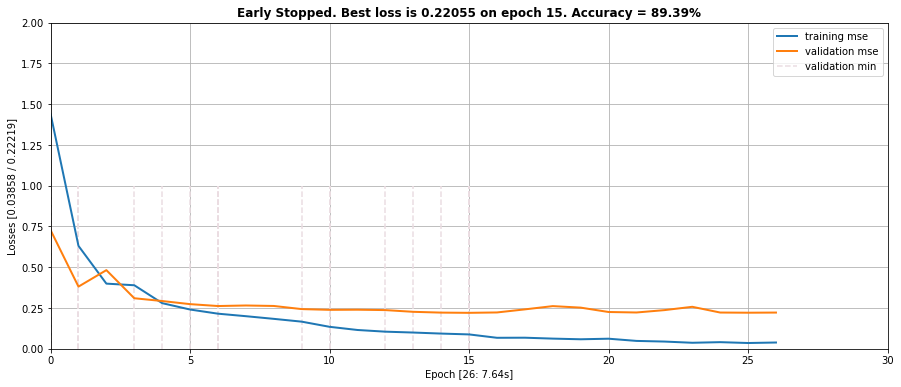

In [9]:
model_name = models_dir+fire_model # toda vez que mudar o modelo, altere o nome dele
ploss = 2.0
nepochs = 30

if True: #not os.path.isfile(model_name + '.model'):
    print("[INFO] creating model...")
    # History, checkpoint, earlystop, plot losses:
    my_big_callback = TrainingPlotter(n=1, filepath=model_name, patience=10)
    
    # initialize the optimizer and model
    print("[INFO] compiling model...")
    vgg16_tr_model.compile(loss="categorical_crossentropy", optimizer='adam', metrics=["accuracy"])    
    
else:
    print("[INFO] loading model...")
    vgg16_tr_model, my_big_callback = load_model_and_history(model_name)

past_epochs = my_big_callback.get_nepochs()

fig = plt.figure(figsize=(15,6))
plt.ylim(0.0, ploss)
plt.xlim(0, nepochs)
plt.grid(True)

print("[INFO] training...")
try:
    vgg16_tr_model.fit(X_train, Y_train, batch_size=128, nb_epoch=nepochs,
                       verbose=0, validation_split=0.33, callbacks = [my_big_callback])
except KeyboardInterrupt:
    pass

print("[INFO] evaluating...")
loss, accuracy = vgg16_tr_model.evaluate(X_test, Y_test, batch_size=128, verbose=0)

print("[INFO] accuracy: {:.2f}%".format(accuracy * 100))

## Salvando os pesos da rede treinada

In [10]:
# Habilita todas as camadas para o salvamento
for layer in vgg16_tr_model.layers:
    layer.trainable = True
    
vgg16_tr_model.save_weights(models_dir+fire_vgg16_name)